In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# coordinates_list = [[0.9, 0.9],
#                     [0.8, 1],
#                     [0.9, 1.1],
#                     [1, 1]]


# a = ([[  6.48076197,   9.86263944,  -0.27829966],
#        [  5.51923803,  10.13736056,  -0.27829966],
#        [  7.14367394,   7.47891314,   1.27933953],
#        [  6.85632606,   6.52108686,   1.27933953],
#        [ 10.48809353,  10.10846523,  -2.92292371],
#        [  9.51190647,   9.89153477,  -2.92292371],
#        [  8.08219949,  11.49319696,  -1.735945  ],
#        [  7.91780051,  10.50680304,  -1.735945  ]])

# print(filter_outer(a))

In [3]:
def get_rt(alpha, x):
    s, c = np.sin(alpha), np.cos(alpha)
    r = np.array([[c, s], [-s, c]])
    rotated = np.dot(r, x)
    return rotated

def calculate_distance(coords1, coords2):
    theta_diff = None
    distance_map_frame = coords2[:2] - coords1[:2]
    if len(coords1) == 3 and len(coords2) == 3:
        theta_diff = wrap_angle(coords2[2] - coords1[2])
    return distance_map_frame, theta_diff

def wrap_angle(angle):
    """
    Wraps the given angle to the range [-pi, +pi].
    :param angle: The angle (in rad) to wrap (can be unbounded).
    :return: The wrapped angle (guaranteed to in [-pi, +pi]).
    """
    return (angle + np.pi) % (np.pi * 2) - np.pi

def rotate(a, b, c):
    return (b[0] - a[0]) * (c[1] - b[1]) - (b[1] - a[1]) * (c[0] - b[0])

def find_outer(coords):
    """
    filter out inner landings
    input: [(x0, y0), (x1, y1), ...]
    jarvis march
    :return: convex hull, list of coordinates, TODO counter or clockwise, need to figure out
    """
    a = coords
    n = len(a)
    p = range(n)
    # start point
    for i in range(1, n):
        if a[p[i]][0] < a[p[0]][0]:
            p[i], p[0] = p[0], p[i]
    h = [p[0]]
    del p[0]
    p.append(h[0])
    while True:
        right = 0
        for i in range(1, len(p)):
            if rotate(a[h[-1]], a[p[right]], a[p[i]]) < 0:  # FIXME
                right = i
        if p[right] == h[0]:
            break
        else:
            h.append(p[right])
            del p[right]
    #hull = [a[i] for i in h]
    return h

def transformation_matrix(x, y, theta):
    return np.array([[np.cos(theta), -np.sin(theta), x],
                     [np.sin(theta), np.cos(theta), y],
                     [0, 0, 1]])

def plot_vehicle(x, y, theta):
    # Corners of triangular vehicle when pointing to the right (0 radians)

    p1_i = np.array([0.03, 0, 1]).T
    p2_i = np.array([-0.02, 0.01, 1]).T
    p3_i = np.array([-0.02, -0.01, 1]).T

    T = transformation_matrix(x, y, theta)
    p1 = np.matmul(T, p1_i)
    p2 = np.matmul(T, p2_i)
    p3 = np.matmul(T, p3_i)

    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'g-')
    ax.plot([p2[0], p3[0]], [p2[1], p3[1]], 'g-')
    ax.plot([p3[0], p1[0]], [p3[1], p1[1]], 'g-')

In [4]:
# pucks_in_frame = np.array([[0.6, 0.10], [0.7, 0.7], [0.10, 0.10], [0.8, 0.11]])

pucks_in_frame = np.array([[0.7, 0.8],
                            [0.9, 0.9],
                            [1.1, 0.85],
                            [0.9, 1.1]])

# hull = [[9, 9],
#         [8, 10],
#         [9, 11],
#         [10, 10]]

# rot_hull = [get_rt(0, node) for node in hull]
# rot_hull = np.array(rot_hull)

# pucks_in_frame = np.array([[0.93900626, 0.99461677],
#                              [1.04959243, 1.00593718],
#                              [1.05693593, 1.12152614],
#                              [0.94454928, 1.14355901]])

# pucks_in_frame = np.array([[0.93900626, 0.99461677],
#                              [1.04959243, 1.00593718],
#                              [1.05693593, 1.12152614]])

ind = find_outer(pucks_in_frame)
rot_hull = np.array([pucks_in_frame[i] for i in ind])

approach_dist = 0.11  # cm
mc = np.mean(rot_hull, axis = 0)
offset = list(rot_hull)  # a miserable attempt to copy a list
offset -= mc  # Normalize the polygon by subtracting the center values from every point.
offset *= 2
offset += mc

In [5]:
landings_coordinates = []
for orig, ofs in zip(rot_hull, offset):
#     print(" ")
#     print("orig")
#     print(orig)
#     print(" ")
#     print("ofs")
#     print(ofs)
    dist, _ = calculate_distance(ofs, orig)
#     print(dist)
    gamma = np.arctan2(dist[1], dist[0])  # and here we calculate slope of outer bis
    # print("gamma = ", np.rad2deg(gamma))
    x_landing1 = np.sqrt(approach_dist**2 / (1 + np.tan(gamma)**2))
    x_landing2 = - np.sqrt(approach_dist**2 / (1 + np.tan(gamma)**2))
    
    y_landing1 = np.tan(gamma) * x_landing1 
    y_landing2 = np.tan(gamma) * x_landing2
    
    landing1 = np.array([x_landing1 + orig[0], y_landing1 + orig[1], gamma])  # np.rad2deg
    landing2 = np.array([x_landing2 + orig[0], y_landing2 + orig[1], gamma])
    landings_coordinates.append(landing1)
    landings_coordinates.append(landing2)
    
landings = np.array(landings_coordinates)
# print(landings)
ind_land = find_outer(landings[:, :2])
# print(ind_land)
landings = np.array([landings_coordinates[i] for i in ind_land])

In [6]:
pucks_in_frame = np.array([[0.9, 0.9],
                            [1.06, 0.98],
                            [0.98, 0.82],
                            [0.98, 0.9]])

# landings = np.array([[ 0.79,  0.9 ,  0.  ], 
#                      [ 0.98      ,  0.71      ,  1.57079633], 
#                      [ 1.13778175,  1.05778175,  3.92699082]])

landings = np.array([[ 0.94521495,  0.71564484,  1.24904577], 
                     [ 1.12101702,  1.07152553,  4.12438638]])

cands = np.array([[ 1.09      ,  0.9       ,  6.28318531],
                    [ 0.87      ,  0.9       ,  6.28318531]])

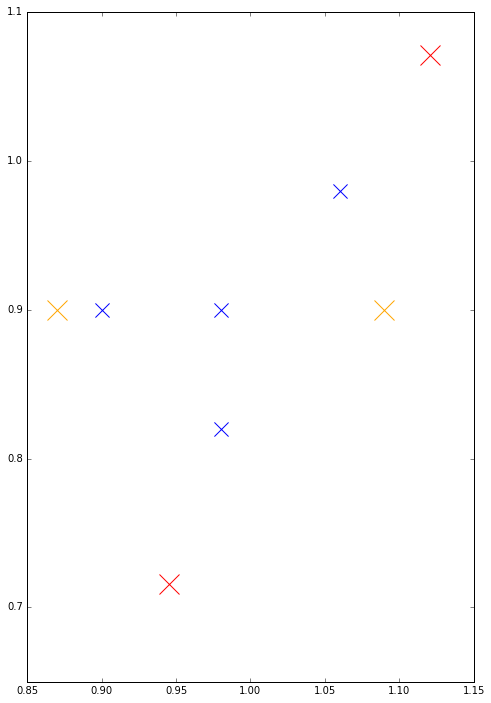

In [7]:
fig = plt.gcf()
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

# ax.scatter(offset[:, 0], offset[:, 1], c = "r", marker="s",  s=50)
# ax.scatter(test[:, 0], test[:, 1], c = "r", marker="s",  s=50)

# ax.scatter(hull[:, 0], hull[:, 1], c = "r")

# ax.scatter(rot_hull[:, 0], rot_hull[:, 1], c = "b", marker="o",  s=50)
ax.scatter(pucks_in_frame[:, 0], pucks_in_frame[:, 1], marker="x",  s=200)
ax.scatter(landings[:, 0], landings[:, 1], c = "r", marker="x",  s=400)
ax.scatter(cands[:, 0], cands[:, 1], c = "orange", marker="x",  s=400)

# # good
# for landing in landings:
#     # print(landing)
#     x = landing[0]
#     y = landing[1]
#     theta = landing[2]
#     # print(theta)
#     plot_vehicle(x, y, theta)

# for rot, ofs in zip(rot_hull, offset):
#     # print(rot, ofs)
#     x = [rot[0], ofs[0]]
#     y = [rot[1], ofs[1]]
#     ax.plot(x, y)

# landings2 = list(landings)
# for i in landings2:
#     print("i is")
#     print(i)
#     print("")
    #ax.plot(k+mc[0], np.tan(i[2])*k+mc[1])
    
#ax.scatter(offset[:, 0], offset[:, 1], c = "y")
ax.set_aspect('equal')
plt.show()

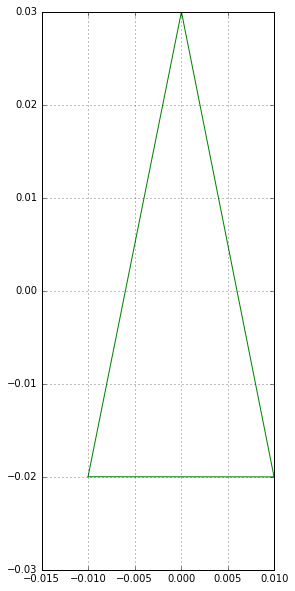

In [8]:
fig = plt.gcf()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

landing = np.array([0, 0, 1.57])
x = landing[0]
y = landing[1]
theta = landing[2]
    
plot_vehicle(x, y, theta)

ax.set_aspect('equal')
plt.grid()
plt.show()

In [9]:
# from math import tan
# fig = plt.gcf()
# fig, ax = plt.subplots()
# for i in landings2:
#     print("i is")
#     print(tan(i[2]))
#     print("")
#     ax.plot(t+mc[0], tan(i[2])*t+mc[1])
    
# #ax.scatter(offset[:, 0], offset[:, 1], c = "y")

# plt.show()

            # a = self.known_coords_of_chaos_pucks
            # b = self.sorted_chaos_landing_coordinates
            # a, b = self.execute_current_puck_cmd(a, b)
            # this doesn't work

In [10]:
candidates = np.array([[ 0.83128354,  1.18589557,  5.38712992],
                         [ 0.96871646,  1.01410443,  5.38712992], 
                         [ 1.16871646,  0.76410443,  2.24553727], 
                         [ 1.03128354,  0.93589557,  2.24553727]])

In [11]:
is_horizontal = [True if abs(candidates[0][2]) < 1e-4 else False]
is_horizontal

[False]

In [12]:
indexes = []
# test = candidates[:, :2]
is_horizontal = [True if abs(candidates[0][2]) < 1e-4 else False]
print(is_horizontal)
if is_horizontal:
    srt = np.argsort(candidates[:,0],axis=0)
else:
    srt = np.argsort(candidates[:,1],axis=0)
srt

# in numpy array no key argument. make list and proceed with lambda
# test = list(candidates[:, :2])
# test.sort(key = lambda (t, k): t**2 + k**2)
# landing_max = candidates[:, :2].sort(key = lambda t, k: t**2 + k**2, reverse=True)

indexes.append(srt[0])
indexes.append(srt[-1])
print(indexes)
print(candidates[0])
print(candidates[2])

[False]
[0, 2]
[ 0.83128354  1.18589557  5.38712992]
[ 1.16871646  0.76410443  2.24553727]


In [13]:
point = np.array([ 0.9,  1.1])
point = np.hstack((point,2))
point

array([ 0.9,  1.1,  2. ])

In [14]:
x2 = np.array([5, 4, 3])
x2_new = x2[np.newaxis, :]
x2_new

array([[5, 4, 3]])

## Calculating area of a polygon and choosing threshold

In [15]:
def polygon_area(x,y):
    # coordinate shift
    x_ = x - x.mean()
    y_ = y - y.mean()
    # everything else is the same as maxb's code
    correction = x_[-1] * y_[0] - y_[-1]* x_[0]
    main_area = np.dot(x_[:-1], y_[1:]) - np.dot(y_[:-1], x_[1:])
    return 0.5*np.abs(main_area + correction)

In [16]:
import sys
sys.path

['',
 '/opt/ros/kinetic/lib/python2.7/dist-packages',
 '/home/safoex/eurobot2019_ws/src/ros-eurobot-2019/libs',
 '/usr/lib/python2.7',
 '/usr/lib/python2.7/plat-x86_64-linux-gnu',
 '/usr/lib/python2.7/lib-tk',
 '/usr/lib/python2.7/lib-old',
 '/usr/lib/python2.7/lib-dynload',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages/PILcompat',
 '/usr/lib/python2.7/dist-packages/gtk-2.0',
 '/usr/lib/python2.7/dist-packages/wx-3.0-gtk2',
 '/usr/local/lib/python2.7/dist-packages/IPython/extensions',
 '/home/safoex/.ipython']

## Calculating angles of a polygon and sorting them

In [17]:
import numpy as np

In [18]:
from sympy import Point, Polygon
from math import radians, degrees

In [19]:
pucks_in_frame2 = np.array([[0.9, 0.9],
                            [1.06, 0.98],
                            [0.98, 0.82],
                            [0.98, 0.9]])

pucks_in_frame = np.array([ [1.06, 0.98],
                            [0.98, 0.82],
                            [0.98, 0.9]])

candidates = np.array([[ 0.94521495,  0.71564484,  1.24904577],
                         [ 1.12101702,  1.07152553,  4.12438638],
                         [ 0.87,        0.9,         6.28318531]])

test = np.array([[ 0.87,        0.9,         6.28318531],
                 [ 0.94521495,  0.71564484,  1.24904577],
                 [ 1.12101702,  1.07152553,  4.12438638]])

one_inside = np.array([[0.7, 0.8],
                        [0.9, 0.9],
                        [1.1, 0.85],
                        [0.9, 1.1]])

('hull is: ', [array([ 0.9,  0.9]), array([ 1.06,  0.98]), array([ 0.98,  0.82]), array([ 0.98,  0.9 ])])
 

(Point2D(9/10, 9/10), Point2D(53/50, 49/50), Point2D(49/50, 41/50), Point2D(49/50, 9/10))


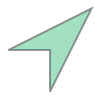

In [20]:
# this depicts an arrow! :)

hull = list(pucks_in_frame2)
print("hull is: ", hull)
p1, p2, p3, p4 = map(Point, hull)  # need to unpack hull?
print(" \n")
print(p1, p2, p3, p4)
poly = Polygon(p1, p2, p3, p4)
poly
# angles = calculate_and_sort_by_inner_angles(hull)
# angles

In [21]:
def calculate_and_sort_by_inner_angles(test):
    """
    Input:
    hull

    Calculates inner angles of a convex hull
    Sorts them
    Removes DANGEROUS angles that are below threshold safe level

    :return: sorted list of safe angles starting with sharpest one
    """
    candidates = np.array(test)
    if len(hull) == 4:        
        p1, p2, p3, p4 = map(Point, candidates[:, :2])  # need to unpack hull?
        poly = Polygon(p1, p2, p3, p4)
    elif len(hull) == 3:
        p1, p2, p3 = map(Point, candidates[:, :2])  # need to unpack hull?
        poly = Polygon(p1, p2, p3)        
    
    vertices_angles_raw = poly.angles.items()
    vertices_angles = [[(float(k[0].x), float(k[0].y)), radians(degrees(k[1]))] for k in vertices_angles_raw]
    vertices_angles.sort(key=lambda t: t[1])  # sorts by calculated angle
    vertices_angles = np.array(vertices_angles)

    print("vertices_angles")
    print(vertices_angles)  # [[(1.12101702, 1.07152553), 0.5125220134823292], ...]
    print(" ")
    
    if any(vertices_angles[:3, 1] > 2):
        is_hull_safe_to_approach = False
    elif all(vertices_angles[:3, 1] < 2):
        is_hull_safe_to_approach = True
    
    sorted_vertices_by_angle = np.array([v[0] for v in vertices_angles])
    return is_hull_safe_to_approach, sorted_vertices_by_angle


hull = list(test)
print(hull)
print(" ")
flag, landings_sorted_by_angles = calculate_and_sort_by_inner_angles(hull)
print(flag, landings_sorted_by_angles)

[array([ 0.87      ,  0.9       ,  6.28318531]), array([ 0.94521495,  0.71564484,  1.24904577]), array([ 1.12101702,  1.07152553,  4.12438638])]
 
vertices_angles
[[(1.12101702, 1.07152553) 0.5125220134823292]
 [(0.94521495, 0.71564484) 0.8462040981306261]
 [(0.87, 0.9) 1.7828665419768381]]
 
(True, array([[ 1.12101702,  1.07152553],
       [ 0.94521495,  0.71564484],
       [ 0.87      ,  0.9       ]]))


In [22]:
landings_sorted_by_angles[:2]

array([[ 1.12101702,  1.07152553],
       [ 0.94521495,  0.71564484]])

In [23]:
if all([1>0, 2>1, 3>4]):
    print(True)
else:
    print(False)

False


In [24]:
testt = [1, 2, 3, 4]
indexes = []

In [25]:
indexes = []
indexes.append(testt.pop(0))
indexes.append(testt.pop(-1))
indexes.append(testt.pop(0))
indexes.append(testt.pop(0))
# 1 4 2 3
indexes

[1, 4, 2, 3]

In [26]:
x = np.arange(9)
x2 = np.reshape(x, (3,3))
x2

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [27]:
next1 = np.roll(x2, -1, axis=0)
prev1 = np.roll(x2, 1, axis=0)

In [28]:
prev1

array([[6, 7, 8],
       [0, 1, 2],
       [3, 4, 5]])

In [29]:
next1

array([[3, 4, 5],
       [6, 7, 8],
       [0, 1, 2]])

In [30]:
x2

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

## Check if the next puck is blue one

In [31]:
puck = np.array([[0, 0.95, 1.1, 0, 0, 1], [1, 0.9, 1.3, 0, 1, 0]])
if all(puck[0][3:6] == [0, 0, 1]):
    print(True)
else:
    print(False)

True


In [32]:
def rotate(a, b, c):
    return (b[0] - a[0]) * (c[1] - b[1]) - (b[1] - a[1]) * (c[0] - b[0])

def calculate_convex_hull(coords):
    """
    jarvis march
    input: [(x0, y0), (x1, y1), ...]
    :return: convex hull, INDEXES of coordinates in input list, not coords themselves, TODO counter or clockwise, need to figure out
    """
    n = len(coords)
    p = range(n)
    # start point
    for i in range(1, n):
        if coords[p[i]][0] < coords[p[0]][0]:
            p[i], p[0] = p[0], p[i]
    h = [p[0]]
    del p[0]
    p.append(h[0])
    while True:
        right = 0
        for i in range(1, len(p)):
            if rotate(coords[h[-1]], coords[p[right]], coords[p[i]]) < 0:  # FIXME
                right = i
        if p[right] == h[0]:
            break
        else:
            h.append(p[right])
            del p[right]

    # hull = [coords[i] for i in h]  # this was used to extract coords from input list using calculated indexes
    return h

def wrap_angle(angle):

    """
    Wraps the given angle to the range [-pi, +pi].
    :param angle: The angle (in rad) to wrap (can be unbounded).
    :return: The wrapped angle (guaranteed to in [-pi, +pi]).
    """

    return (angle + np.pi) % (2 * np.pi) - np.pi


def wrap_back(angle):
    """

    :param angle: (-pi, pi)
    :return: (0, 2*pi)
    """
    return (angle + 2 * np.pi) % (2 * np.pi)


def calculate_distance(coords1, coords2):
    """
    Calculates x_diff, y_diff between two points
    Calculates x_diff, y_diff and theta_diff between two vectors and wrapes angle so it lies
    :param coords1:
    :param coords2:
    :return:
    """
    #print(coords1)
    #print(coords2)
    theta_diff = None
    distance_map_frame = coords2[:2] - coords1[:2]
    # distance_map_frame = coords2[:, :2] - coords1[:, :2]

    if len(coords1) == 3 and len(coords2) == 3:
        theta_diff = wrap_angle(coords2[2] - coords1[2])
    return distance_map_frame, theta_diff

def batch_calculate_distance(coords1, coords2):
    """
    Calculates x_diff, y_diff between two points
    Calculates x_diff, y_diff and theta_diff between two vectors and wrapes angle so it lies
    :param coords1:
    :param coords2:
    :return:
    """
    #print(coords1)
    #print(coords2)
    distance_map_frame = coords2[:, :2] - coords1[:, :2]
    return distance_map_frame

def polygon_area(hull):
    x = np.array([h[0] for h in hull])
    y = np.array([h[1] for h in hull])  # because slicing doesn't work for some reason
    # coordinate shift
    x_ = x - np.mean(x)
    y_ = y - np.mean(y)
    correction = x_[-1] * y_[0] - y_[-1] * x_[0]
    main_area = np.dot(x_[:-1], y_[1:]) - np.dot(y_[:-1], x_[1:])
    return 0.5*np.abs(main_area + correction)

## Test to calculate inner angles

In [33]:
# def calc_inner_angles(coords):
#     print("coords")
#     print(coords)
    
#     hull_indexes = calculate_convex_hull(coords)
#     hull = np.array([coords[i] for i in hull_indexes])  # using returned indexes to extract hull's coords
#     print("hull")
#     print(hull)
    
#     next_ = np.roll(hull, -1, axis=0)
#     prev_ = np.roll(hull, 1, axis=0)
#     print("prev_")
#     #print(prev_)
#     print(prev_[:, :2])
#     print("next")
#     print(next_)
    
#     prev_dist, _ = calculate_distance(hull[:, :2], prev_[:, :2])
#     next_dist, _ = calculate_distance(hull[:, :2], next_[:, :2])
#     print(" ")
#     print("prev_dist")
#     print(prev_dist)
#     print("prev_dist[:, 1]")
#     print(prev_dist[:, 1])
#     print(" ")
#     print("next_dist")
#     print(next_dist)
    
    
#     prev_a = np.arctan2(prev_dist[:, 1], prev_dist[:, 0])
#     next_a = np.arctan2(next_dist[:, 1], next_dist[:, 0])
#     #angles = next_a - prev_a
#     print("prev_a")
#     print(prev_a)
    
#     angles = wrap_angle(prev_a - next_a)
#     print("angles")
#     print(angles)
    
#     coords_angles = list(zip(hull, angles))
#     coords_angles.sort(key = lambda t: t[1])
#     print("coords_angles")
#     print(coords_angles)
#     print(" ")
#     coords_sorted = np.array([v[0] for v in coords_angles])

#     return coords_sorted

In [41]:
def calc_inner_angles(coords):
    is_line = polygon_area(coords)
    # print(is_streigt_line)
    # is_streigt_line = True
    if is_line < 1e-4:
        # print("indeed straigt")
        raise AttributeError('pucks lie on a straigt line, so no angles')
    
    else:
        hull_indexes = calculate_convex_hull(coords)
        hull = np.array([coords[i] for i in hull_indexes])  # using returned indexes to extract hull's coords

        next_ = np.roll(hull, -1, axis=0)
        prev_ = np.roll(hull, 1, axis=0)

        prev_dist = batch_calculate_distance(hull[:, :2], prev_[:, :2])
        next_dist = batch_calculate_distance(hull[:, :2], next_[:, :2])

        prev_a = np.arctan2(prev_dist[:, 1], prev_dist[:, 0])
        next_a = np.arctan2(next_dist[:, 1], next_dist[:, 0])
        angles = wrap_angle(prev_a - next_a)

        coords_angles = list(zip(hull, angles))
        coords_angles.sort(key = lambda t: t[1])

        coords_sorted = np.array([v[0] for v in coords_angles])
        angles_sorted = np.array([v[1] for v in coords_angles])
    
        return coords_sorted, angles_sorted

In [42]:
coords = np.array([[0.7, 0.8, 0, 0],
                    [0.8, 0.95, 1, 0],
                    [0.9, 0.85, 2, 0],
                    [1, 1.1, 3, 0]])

pucks_in_frame3 = np.array([[0.9, 0.9, 0, 0, 1, 0],
                            [1.06, 0.98, 1, 1, 0, 0],
                            [0.98, 0.82, 2, 0, 0, 1],
                            [0.98, 0.9, 3, 0, 1, 0]])

# horizontal line - fails
coordinates_list6 = np.array([[0.9, 0.9],
                            [0.9, 1],
                            [0.9, 1.1],
                            [0.9, 1.2]])

coordinates_list9 = np.array([[0.9, 0.9],
                            [1, 1],
                            [1.1, 1.1],
                            [1.2, 1.2]])
# works - 2-4 non-perfect diagonal
coordinates_list10 = np.array([[0.91, 0.9],
                            [0.99, 1],
                            [1.12, 1.1],
                            [1.18, 1.2]])


try:
    c, a = calc_inner_angles(coordinates_list9)
    c, a
except AttributeError:
    print("ok")

ok


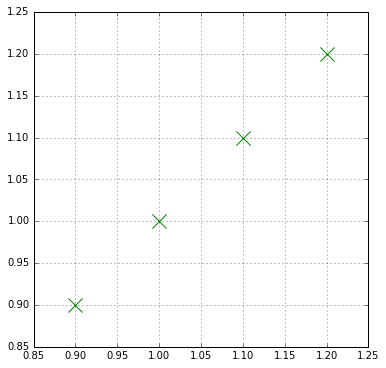

In [36]:
# a = coords[:, :2]
a = coordinates_list9[:, :2]

def transformation_matrix(x, y, theta):
    return np.array([[np.cos(theta), -np.sin(theta), x],
                     [np.sin(theta), np.cos(theta), y],
                     [0, 0, 1]])

def plot_vehicle(x, y, theta):
    # Corners of triangular vehicle when pointing to the right (0 radians)

    p1_i = np.array([0.03, 0, 1]).T
    p2_i = np.array([-0.02, 0.01, 1]).T
    p3_i = np.array([-0.02, -0.01, 1]).T

    T = transformation_matrix(x, y, theta)
    p1 = np.matmul(T, p1_i)
    p2 = np.matmul(T, p2_i)
    p3 = np.matmul(T, p3_i)

    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'g-')
    ax.plot([p2[0], p3[0]], [p2[1], p3[1]], 'g-')
    ax.plot([p3[0], p1[0]], [p3[1], p1[1]], 'g-')
    
fig = plt.gcf()
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

# ax.scatter(offset[:, 0], offset[:, 1], c = "r", marker="s",  s=50)
#ax.scatter(test[:, 0], test[:, 1], c = "r", marker="s",  s=50)

#ax.scatter(rot_hull[:, 0], rot_hull[:, 1], c = "b", marker="o",  s=50)
ax.scatter(a[:, 0], a[:, 1], c = "g", marker="x",  s=200)
#ax.scatter(candidates[:, 0], candidates[:, 1], c = "r", marker="x",  s=400)

# for landing in landings:
#     # print(landing)
#     x = landing[0]
#     y = landing[1]
#     theta = landing[2]
#     # print(theta)
#     plot_vehicle(x, y, theta)
    
#ax.scatter(offset[:, 0], offset[:, 1], c = "y")
ax.set_aspect('equal')
plt.grid()
plt.show()